In [3]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from scipy.linalg import solve, block_diag

module_path = os.path.abspath(os.path.join('../../src'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from dynamics_new import a_grav, da_grav_dp_vec, d2a_grav_dp_vec_dp_vecT, a_J2, da_J2_dp_vec, d2a_J2_dp_vec_dp_vecT, a_drag, da_drag_dp_vec, da_drag_dv_vec, d2a_drag_dp_vec_dp_vecT, d2a_drag_dp_vec_dv_vecT, d2a_drag_dv_vec_dp_vecT, d2a_drag_dv_vec_dv_vecT
from utils import get_form_initial_conditions

In [4]:
# Simulation parameters
dt = 60.0  # Time step [s]
K = 395  # Duration [min]
M = 1  # Number of Monte-Carlo simulations
N = 4  # Number of satellites
formation = 1
n_x = 6 
n_p = 3  
n = N * n_x
o = 3 + 3 + 2 + 1 
H = 50 # Window size [min]
invalid_rmse = 1e20 # [m]

In [5]:
# Observation noise
r_chief_pos = 1e-1  # [m]
R_chief = np.diag(np.concatenate([r_chief_pos * np.ones(3)])) ** 2
r_deputy_pos = 1e0  # [m]
R_deputies = np.diag(np.concatenate([r_deputy_pos * np.ones(6)])) ** 2
R = block_diag(R_chief, R_deputies)

# Initial deviation noise
p_pos_initial = 1e2  # [m]
p_vel_initial = 1e-2  # [m / s]
P_0 = np.diag(np.concatenate([p_pos_initial * np.ones(3), p_vel_initial * np.ones(3)])) ** 2
P_0 = block_diag(P_0, P_0, P_0, P_0)

In [6]:
def diff_eq(x_vec):
    x_dot_vec = np.zeros_like(x_vec)
    for i in range(N):
        x_vec_i = x_vec[i * n_x : i * n_x + n_x]
        v_vec_i = x_vec_i[n_p : n_x] 
        x_dot_vec[i * n_x : i * n_x + n_x] = np.concatenate((v_vec_i, a_grav(x_vec_i) + a_J2(x_vec_i) + a_drag(x_vec_i)))
    return x_dot_vec

def Ddiff_eq(x_vec):
    first_order_der = np.zeros((n, n))
    for i in range(N):
        x_vec_i = x_vec[i * n_x : i * n_x + n_x]
        first_order_der[i * n_x : i * n_x + n_p, i * n_x + n_p : i * n_x + n_x] = np.eye(n_p)
        first_order_der[i * n_x + n_p : i * n_x + n_x, i * n_x : i * n_x + n_p] = da_grav_dp_vec(x_vec_i) + da_J2_dp_vec(x_vec_i) + da_drag_dp_vec(x_vec_i)
        first_order_der[i * n_x + n_p : i * n_x + n_x, i * n_x + n_p : i * n_x + n_x] = da_drag_dv_vec(x_vec_i)
    return first_order_der

def Hdiff_eq(x_vec):
    second_order_der = np.zeros((n, n, n))
    for i in range(N):
        x_vec_i = x_vec[i * n_x : i * n_x + n_x]
        aux_pp = (d2a_grav_dp_vec_dp_vecT(x_vec_i) + d2a_J2_dp_vec_dp_vecT(x_vec_i) + d2a_drag_dp_vec_dp_vecT(x_vec_i)).reshape((n_p, n_p, n_p))
        aux_pv = d2a_drag_dp_vec_dv_vecT(x_vec_i).reshape((n_p, n_p, n_p))
        aux_vp = d2a_drag_dv_vec_dp_vecT(x_vec_i).reshape((n_p, n_p, n_p))
        aux_vv = d2a_drag_dv_vec_dv_vecT(x_vec_i).reshape((n_p, n_p, n_p))
        for j in range(n_p): 
            second_order_der[i * n_x + n_p : i * n_x + n_x, i * n_x : i * n_x + n_p, i * n_x + j] = aux_pp[:, :, j]
            second_order_der[i * n_x + n_p : i * n_x + n_x, i * n_x : i * n_x + n_p, i * n_x + j + n_p] = aux_pv[:, :, j]
            second_order_der[i * n_x + n_p : i * n_x + n_x, i * n_x + n_p : i * n_x + n_x, i * n_x + j] = aux_vp[:, :, j]
            second_order_der[i * n_x + n_p : i * n_x + n_x, i * n_x + n_p : i * n_x + n_x, i * n_x + j + n_p] = aux_vv[:, :, j]
    return second_order_der.reshape((n * n, n))

def f(dt, x_old):
    k1 = diff_eq(x_old)
    k2 = diff_eq(x_old + dt / 2 * k1)
    k3 = diff_eq(x_old + dt / 2 * k2)
    k4 = diff_eq(x_old + dt * k3)
    return x_old + dt / 6 * (k1 + 2 * k2 + 2 * k3 + k4)

def Df(dt, x_old):
    k1 = diff_eq(x_old)
    k2 = diff_eq(x_old + dt / 2 * k1)
    k3 = diff_eq(x_old + dt / 2 * k2)

    Dk1 = Ddiff_eq(x_old)
    Dk2 = Ddiff_eq(x_old + dt / 2 * k1) @ (np.eye(n) + dt / 2 * Dk1)
    Dk3 = Ddiff_eq(x_old + dt / 2 * k2) @ (np.eye(n) + dt / 2 * Dk2)
    Dk4 = Ddiff_eq(x_old + dt * k3) @ (np.eye(n) + dt * Dk3)
    return np.eye(n) + dt / 6 * (Dk1 + 2 * Dk2 + 2 * Dk3 + Dk4)

def Hf(dt, x_old):
    k1 = diff_eq(x_old)
    k2 = diff_eq(x_old + dt / 2 * k1)
    k3 = diff_eq(x_old + dt / 2 * k2)

    Dk1 = Ddiff_eq(x_old)
    Dk2 = Ddiff_eq(x_old + dt / 2 * k1) @ (np.eye(n) + dt / 2 * Dk1)
    Dk3 = Ddiff_eq(x_old + dt / 2 * k2) @ (np.eye(n) + dt / 2 * Dk2)

    Hk1 = Hdiff_eq(x_old)
    Hk2 = np.kron(np.eye(n), np.eye(n) + dt / 2 * Dk1).T @ Hdiff_eq(x_old + dt / 2 * k1) @ (np.eye(n) + dt / 2 * Dk1) + np.kron(Ddiff_eq(x_old + dt / 2 * k1), np.eye(n)) @ (dt / 2 * Hk1)
    Hk3 = np.kron(np.eye(n), np.eye(n) + dt / 2 * Dk2).T @ Hdiff_eq(x_old + dt / 2 * k2) @ (np.eye(n) + dt / 2 * Dk2) + np.kron(Ddiff_eq(x_old + dt / 2 * k2), np.eye(n)) @ (dt / 2 * Hk2)
    Hk4 = np.kron(np.eye(n), np.eye(n) + dt * Dk3).T @ Hdiff_eq(x_old + dt * k3) @ (np.eye(n) + dt * Dk3) + np.kron(Ddiff_eq(x_old + dt * k3), np.eye(n)) @ (dt * Hk3)
    return dt / 6 * (Hk1 + 2 * Hk2 + 2 * Hk3 + Hk4)

In [7]:
def h(x_vec):
    p_vecs = [x_vec[i : i + n_p] for i in range(0, n, n_x)]
    distances = [np.linalg.norm(p_vecs[j] - p_vecs[i]) for (i, j) in [(1, 0), (1, 2), (1, 3), (2, 0), (2, 3), (3, 0)]]
    return np.concatenate((p_vecs[0], np.array(distances).reshape(-1, 1)))

def Dh(x_vec):
    first_order_der = np.zeros((o, n))
    p_vecs = [x_vec[i : i + n_p] for i in range(0, n, n_x)]
    
    first_order_der[:n_p, :n_p] = np.eye(n_p)
    
    for k, (i, j) in enumerate([(1, 0), (1, 2), (1, 3), (2, 0), (2, 3), (3, 0)], start=n_p):
        d = p_vecs[j] - p_vecs[i]
        norm_d = np.linalg.norm(d)
        first_order_der[k, i * n_x : i * n_x + n_p] = -d.T / norm_d
        first_order_der[k, j * n_x : j * n_x + n_p] = d.T / norm_d
    
    return first_order_der

def Hh(x_vec):
    second_order_der = np.zeros((o, n, n))
    p_vecs = [x_vec[i : i + n_p] for i in range(0, n, n_x)]

    def hessian_distance(d, norm_d):
        I = np.eye(n_p)
        return -(I / norm_d - np.outer(d, d) / norm_d**3)

    for k, (i, j) in enumerate([(1, 0), (1, 2), (1, 3), (2, 0), (2, 3), (3, 0)], start=n_p):
        d = p_vecs[j] - p_vecs[i]
        norm_d = np.linalg.norm(d)
        hess_d = hessian_distance(d, norm_d)
        
        second_order_der[k, i * n_x : i * n_x + n_p, i * n_x : i * n_x + n_p] = -hess_d
        second_order_der[k, i * n_x : i * n_x + n_p, j * n_x : j * n_x + n_p] = hess_d
        second_order_der[k, j * n_x : j * n_x + n_p, i * n_x : i * n_x + n_p] = hess_d
        second_order_der[k, j * n_x : j * n_x + n_p, j * n_x : j * n_x + n_p] = -hess_d
    
    return second_order_der.reshape((o * n, n))

In [8]:
def J_tau(tau, dt, y, x_vec):
    for _ in range(tau):
        x_vec = f(dt, x_vec)
    return 1 / 2 * (y - h(x_vec)).T @ np.linalg.inv(R) @ (y - h(x_vec))

def DJ_tau(tau, dt, y, x_vec):
    STM = np.eye(n)
    for _ in range(tau):
        STM = Df(dt, x_vec) @ STM
        x_vec = f(dt, x_vec)
    return -STM.T @ Dh(x_vec).T @ np.linalg.inv(R) @ (y - h(x_vec))

def HJ_tau(tau, dt, y, x_vec):
    STM = np.eye(n)
    DSTM = np.zeros((n * n, n))
    for _ in range(tau):
        DSTM = np.kron(np.eye(n), STM).T @ Hf(dt, x_vec) @ STM + np.kron(Df(dt, x_vec), np.eye(n)) @ DSTM
        STM = Df(dt, x_vec) @ STM
        x_vec = f(dt, x_vec)
    
    Df_x = STM
    Hf_x = DSTM    
    h_x = h(x_vec)
    Dh_x = Dh(x_vec)
    Hh_x = Hh(x_vec)
    R_inv = np.linalg.inv(R)
    return - (np.kron(R_inv @ (y - h_x), Df_x).T @ Hh_x @ Df_x + np.kron(Dh_x.T @ R_inv @ (y - h_x), np.eye(n)).T @ Hf_x) + Df_x.T @ Dh_x.T @ R_inv @ Dh_x @ Df_x

In [9]:
def J(k, dt, Y, x_vec):
    if k < H - 1 or k + 1 > K:
        raise ValueError("k is out of bounds")
    R_inv = np.linalg.inv(R)
    J_x = 0
    for tau in range(k - H + 1, k + 1):
        y = Y[:, :, tau]
        h_x = h(x_vec)
        J_x += 1 / 2 * (y - h_x).T @ R_inv @ (y - h_x)
        x_vec = f(dt, x_vec)
    return J_x

def DJ(k, dt, Y, x_vec):
    if k < H - 1 or k + 1 > K:
        raise ValueError("k is out of bounds")
    R_inv = np.linalg.inv(R)
    STM = np.eye(n)
    DJ_x = np.zeros((n, 1))
    for tau in range(k - H + 1, k + 1):
        y = Y[:, :, tau]
        DJ_x += -STM.T @ Dh(x_vec).T @ R_inv @ (y - h(x_vec))
        STM = Df(dt, x_vec) @ STM
        x_vec = f(dt, x_vec)
    return DJ_x

def HJ(k, dt, Y, x_vec):
    if k < H - 1 or k + 1 > K:
        raise ValueError("k is out of bounds")
    R_inv = np.linalg.inv(R)
    STM = np.eye(n)
    DSTM = np.zeros((n * n, n))
    HJ_x = np.zeros((n, n))
    for tau in range(k - H + 1, k + 1):
        y = Y[:, :, tau]
        h_x = h(x_vec)
        Dh_x = Dh(x_vec)
        Hh_x = Hh(x_vec)
        Df_x = STM
        Hf_x = DSTM
        HJ_x += - (np.kron(R_inv @ (y - h_x), Df_x).T @ Hh_x @ Df_x + np.kron(Dh_x.T @ R_inv @ (y - h_x), np.eye(n)).T @ Hf_x) + Df_x.T @ Dh_x.T @ R_inv @ Dh_x @ Df_x
        DSTM = np.kron(np.eye(n), STM).T @ Hf(dt, x_vec) @ STM + np.kron(Df(dt, x_vec), np.eye(n)) @ DSTM
        STM = Df(dt, x_vec) @ STM
        x_vec = f(dt, x_vec)
    return HJ_x

In [10]:
class CentralizedNewton:
    def __init__(self, tolerance=1e-6, max_iter=20):
        self.grad_tol = tolerance
        self.max_iter = max_iter
        self.iterations = None
        
        # Storage for results
        self.cost_values = []
        self.gradient_norm_values = []

    def solve(self, k, dt, Y, x_init, x_true):
        x = x_init

        prev_cost_value = None
        prev_gradient_norm_value = None
        prev_global_estimation_error = None

        for iteration in range(self.max_iter):
            # Compute the cost function, gradient of the Lagrangian and Hessian of the Lagrangian
            J_x = J(k, dt, Y, x)
            DJ_x = DJ(k, dt, Y, x)
            HJ_x = HJ(k, dt, Y, x)

            # Convergence tracking
            cost_value = J_x[0][0]
            gradient_norm_value = np.linalg.norm(DJ_x)

            # Store the norms
            self.cost_values.append(cost_value)
            self.gradient_norm_values.append(gradient_norm_value)

            if prev_cost_value is not None:
                cost_value_change = (cost_value - prev_cost_value) / abs(prev_cost_value) * 100
                gradient_norm_value_change = (gradient_norm_value - prev_gradient_norm_value) / abs(prev_gradient_norm_value) * 100
                global_estimation_error_change = (np.linalg.norm(x - x_true) - prev_global_estimation_error) / abs(prev_global_estimation_error) * 100
            prev_cost_value = cost_value
            prev_gradient_norm_value = gradient_norm_value
            prev_global_estimation_error = np.linalg.norm(x - x_true)

            # Check convergence and print metrics
            if gradient_norm_value < self.grad_tol or iteration + 1 == self.max_iter:
                print(f"STOP on Iteration {iteration}\nCost function = {cost_value} ({cost_value_change:.2f}%)\nGradient norm = {gradient_norm_value} ({gradient_norm_value_change:.2f}%)\nGlobal estimation error = {np.linalg.norm(x - x_true)} ({global_estimation_error_change:.2f}%)")
                print(f"Final position estimation errors: {np.linalg.norm(x[:n_p, :] - x_true[:n_p, :])} m, {np.linalg.norm(x[n_x : n_x + n_p, :] - x_true[n_x : n_x + n_p, :])} m, {np.linalg.norm(x[2 * n_x : 2 * n_x + n_p, :] - x_true[2 * n_x : 2 * n_x + n_p, :])} m, {np.linalg.norm(x[3 * n_x : 3 * n_x + n_p, :] - x_true[3 * n_x : 3 * n_x + n_p, :])} m\n")
                break
            else:
                if iteration == 0:
                    print(f"Before applying the algorithm\nCost function: {cost_value}\nGradient norm: {gradient_norm_value}\nGlobal estimation error: {np.linalg.norm(x - x_true)}")
                else:
                    print(f"Iteration {iteration}\nCost function: {cost_value} ({cost_value_change:.2f}%)\nGradient norm: {gradient_norm_value} ({gradient_norm_value_change:.2f}%)\nGlobal estimation error: {np.linalg.norm(x - x_true)} ({global_estimation_error_change:.2f}%)")
                    
            # Print estimation errors 
            print(f"Position estimation errors: {np.linalg.norm(x[:n_p, :] - x_true[:n_p, :])} m, {np.linalg.norm(x[n_x : n_x + n_p, :] - x_true[n_x : n_x + n_p, :])} m, {np.linalg.norm(x[2 * n_x : 2 * n_x + n_p, :] - x_true[2 * n_x : 2 * n_x + n_p, :])} m, {np.linalg.norm(x[3 * n_x : 3 * n_x + n_p, :] - x_true[3 * n_x : 3 * n_x + n_p, :])} m\n")
                
            # Solve for the Newton step - this is one iteration
            delta_x = solve(HJ_x, -DJ_x)
            x += delta_x
        
            # Save the current iteration
            self.iterations = iteration + 1
            
        # Propagate window initial conditions getting estimate at timestamp k
        x_init = x
        for _ in range(H - 1):
            x = f(dt, x)

        return x_init, x

In [11]:
def give_me_the_plots(algorithm_class):
    iterations = np.arange(0, algorithm_class.iterations + 1)

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Plot 1
    axs[0].semilogy(iterations, algorithm_class.cost_values, '.-')
    axs[0].set_xlabel(r'$n$')
    axs[0].set_ylabel(r'$J(x_n)$')
    axs[0].set_title('Cost Function')
    axs[0].grid()

    # Plot 2
    axs[1].semilogy(iterations, algorithm_class.gradient_norm_values, '.-')
    axs[1].set_xlabel(r'$n$')
    axs[1].set_ylabel(r'$||\nabla J(x_n)||_2$')
    axs[1].set_title('Gradient Norm')
    axs[1].grid()

    plt.tight_layout()
    plt.show()

In [12]:
np.random.seed(42)

# Initial conditions for the state vector and true state vectors
X_initial = get_form_initial_conditions(formation)
X_true = np.zeros((n, 1, K))
X_true[:, :, 0] = X_initial
for k in range(K - 1):
    X_true[:, :, k + 1] = f(dt, X_true[:, :, k])

# Observations
Y = np.zeros((o, 1, K))
for k in range(K):
    Y[:, :, k] = h(X_true[:, :, k]) + np.random.multivariate_normal(np.zeros(o), R).reshape((o, 1))
    
# Initial position estimation error
X_est = np.zeros_like(X_true)
X_est[:, :, 0] = X_initial + np.random.multivariate_normal(np.zeros(n), P_0).reshape((n, 1))
for k in range(K - 1):
    X_est[:, :, k + 1] = f(dt, X_est[:, :, k])
position_estimation_error_1_initial = np.linalg.norm(X_est[:n_p, :, :] - X_true[:n_p, :, :], axis=0).reshape(-1, 1)
position_estimation_error_2_initial = np.linalg.norm(X_est[n_x:n_x + n_p, :, :] - X_true[n_x:n_x + n_p, :, :], axis=0).reshape(-1, 1)
position_estimation_error_3_initial = np.linalg.norm(X_est[2 * n_x:2 * n_x + n_p, :, :] - X_true[2 * n_x:2 * n_x + n_p, :, :], axis=0).reshape(-1, 1)
position_estimation_error_4_initial = np.linalg.norm(X_est[3 * n_x:3 * n_x + n_p, :, :] - X_true[3 * n_x:3 * n_x + n_p, :, :], axis=0).reshape(-1, 1)

MC run:   0%|          | 0/1 [00:00<?, ?it/s]

------------------------------------ Monte Carlo run #1 ------------------------------------


Before applying the algorithm
Cost function: 292817403.41881984
Gradient norm: 5458854038.093539
Global estimation error: 412.40688473366384
Position estimation errors: 91.9030372717269 m, 324.53997228141645 m, 157.5789119891446 m, 177.4146593769755 m

Iteration 1
Cost function: 1232271.2661758945 (-99.58%)
Gradient norm: 24140663.701058272 (-99.56%)
Global estimation error: 814.9824626976633 (97.62%)
Position estimation errors: 0.06113791780314331 m, 372.85148329841957 m, 269.1025772591424 m, 672.8751270544788 m

Iteration 2
Cost function: 59429.39014479442 (-95.18%)
Gradient norm: 8188584.349730679 (-66.08%)
Global estimation error: 428.19462535599325 (-47.46%)
Position estimation errors: 0.044459909268754004 m, 105.83734035066567 m, 218.87370009856605 m, 352.4814196338412 m

Iteration 3
Cost function: 23412.85077468795 (-60.60%)
Gradient norm: 813316.9803909892 (-90.07%)
Global estimation error: 272.6010877265197 (-36.34%)
Position estimation errors: 0.044717234481996285 m, 24.61637

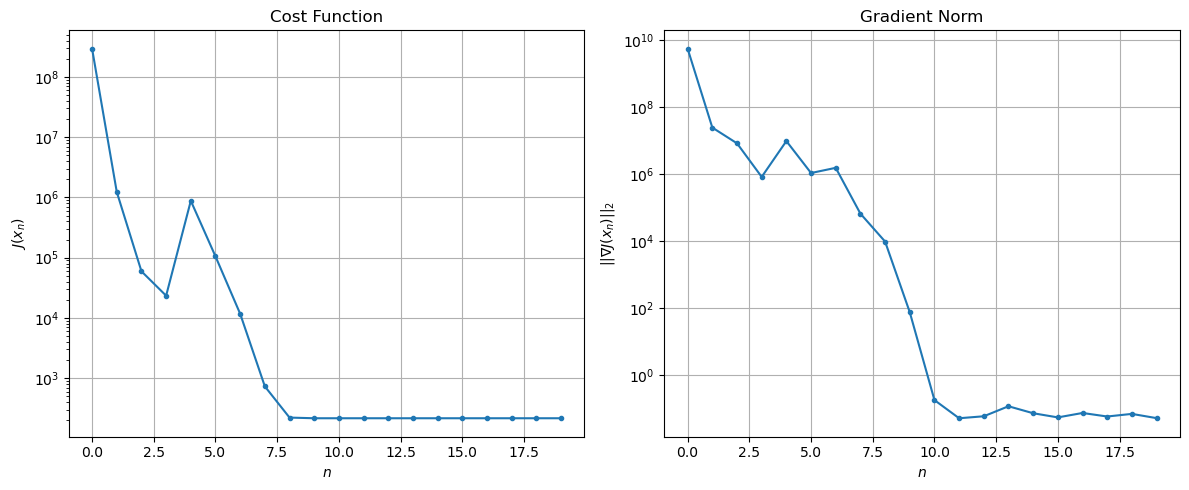

Before applying the algorithm
Cost function: 218.94793250000438
Gradient norm: 193480.3432865802
Global estimation error: 1.576907949796967
Position estimation errors: 0.04378889174759576 m, 0.812898391804797 m, 0.5421491757215524 m, 1.2369269827460665 m

Iteration 1
Cost function: 217.06074102253822 (-0.86%)
Gradient norm: 9.090667298000492 (-100.00%)
Global estimation error: 1.7799160824064189 (12.87%)
Position estimation errors: 0.03666621064373923 m, 1.1543619236018217 m, 0.7393098630447692 m, 1.1347352981633452 m

Iteration 2
Cost function: 217.06073868125765 (-0.00%)
Gradient norm: 0.07296736907815 (-99.20%)
Global estimation error: 1.7797944198845255 (-0.01%)
Position estimation errors: 0.03666620638104181 m, 1.1543753435787023 m, 0.7397738095428553 m, 1.1342283350838331 m

Iteration 3
Cost function: 217.06073854646857 (-0.00%)
Gradient norm: 0.16638924046168987 (128.03%)
Global estimation error: 1.7797944154055672 (-0.00%)
Position estimation errors: 0.03666620662100158 m, 1.15

MC run:   0%|          | 0/1 [03:32<?, ?it/s]


KeyboardInterrupt: 

In [13]:
first_round_stop_iteration = []
K_minus_H_next_rounds_stop_iteration = []
for m in tqdm(range(M), desc="MC run", leave=True):
    print(f"------------------------------------ Monte Carlo run #{m + 1} ------------------------------------")
    Y = np.zeros((o, 1, K))
    for k in range(K):
        Y[:, :, k] = h(X_true[:, :, k]) + np.random.normal(0, np.sqrt(np.diag(R)).reshape((o, 1)), size=(o, 1))

    # Cold-start
    x_init = X_initial + np.random.multivariate_normal(np.zeros(n), P_0).reshape((n, 1))
    
    # Apply the algorithm
    X_est = np.zeros((n, 1, K))
    for k in tqdm(range(H - 1, K), desc="Windows", leave=False):
        centralized_newton = CentralizedNewton()
        x_init, x_est = centralized_newton.solve(k, dt, Y, x_init, X_true[:, :, k - H + 1])
        X_est[:, :, k] = x_est
        
        give_me_the_plots(centralized_newton)

        if k == 0: # Check divergence in the beginning
            position_estimation_error_init_1, position_estimation_error_init_2, position_estimation_error_init_3, position_estimation_error_init_4 = [], [], [], []
            x_est_tau = x_est
            for tau in range(H):
                position_estimation_error_init_1.append(np.linalg.norm(x_est_tau[:n_p, :] - X_true[:n_p, :, tau]))
                position_estimation_error_init_2.append(np.linalg.norm(x_est_tau[n_x:n_x + n_p, :] - X_true[n_x:n_x + n_p, :, tau]))
                position_estimation_error_init_3.append(np.linalg.norm(x_est_tau[2*n_x:2*n_x + n_p, :] - X_true[2*n_x:2*n_x + n_p, :, tau]))    
                position_estimation_error_init_4.append(np.linalg.norm(x_est_tau[3*n_x:3*n_x + n_p, :] - X_true[3*n_x:3*n_x + n_p, :, tau]))
                x_est_tau = f(dt, x_est_tau)
            rmse_init_1 = np.sqrt(np.mean(np.array(position_estimation_error_init_1) ** 2))
            rmse_init_2 = np.sqrt(np.mean(np.array(position_estimation_error_init_2) ** 2))
            rmse_init_3 = np.sqrt(np.mean(np.array(position_estimation_error_init_3) ** 2))
            rmse_init_4 = np.sqrt(np.mean(np.array(position_estimation_error_init_4) ** 2))
            if rmse_init_1 > invalid_rmse or rmse_init_2 > invalid_rmse or rmse_init_3 > invalid_rmse or rmse_init_4 > invalid_rmse:
                print(f"This Monte Carlo run #{m + 1} diverged!")
            else:
                first_round_stop_iteration.append(centralized_newton.iterations)
        else:
            K_minus_H_next_rounds_stop_iteration.append(centralized_newton.iterations)

        # Warm-start
        x_init = f(dt, x_init)

    # After each Monte Carlo Run compute the RMSE_m for each K - H + 1 timestamps
    position_estimation_error_1, position_estimation_error_2, position_estimation_error_3, position_estimation_error_4 = [], [], [], []
    rmse_1, rmse_2, rmse_3, rmse_4 = [], [], [], []
    for k in range(H - 1, K):
        position_estimation_error_1.append(np.linalg.norm(X_est[:n_p, :, k] - X_true[:n_p, :, k]))
        position_estimation_error_2.append(np.linalg.norm(X_est[n_x:n_x + n_p, :, k] - X_true[n_x:n_x + n_p, :, k]))
        position_estimation_error_3.append(np.linalg.norm(X_est[2*n_x:2*n_x + n_p, :, k] - X_true[2*n_x:2*n_x + n_p, :, k]))
        position_estimation_error_4.append(np.linalg.norm(X_est[3*n_x:3*n_x + n_p, :, k] - X_true[3*n_x:3*n_x + n_p, :, k]))
    rmse_m_1 = np.sqrt(np.mean(np.array(position_estimation_error_1) ** 2))
    rmse_m_2 = np.sqrt(np.mean(np.array(position_estimation_error_2) ** 2))
    rmse_m_3 = np.sqrt(np.mean(np.array(position_estimation_error_3) ** 2))
    rmse_m_4 = np.sqrt(np.mean(np.array(position_estimation_error_4) ** 2))
    print(f'This MC run RMSE for the {K - H + 1} timestamps:')
    print(f'RMSE_run{m + 1}_1 = {rmse_m_1}')
    print(f'RMSE_run{m + 1}_2 = {rmse_m_2}')
    print(f'RMSE_run{m + 1}_3 = {rmse_m_3}')
    print(f'RMSE_run{m + 1}_4 = {rmse_m_4}\n')
    if rmse_m_1 > invalid_rmse or rmse_m_2 > invalid_rmse or rmse_m_3 > invalid_rmse or rmse_m_4 > invalid_rmse:
        print(f"Discarding this Monte Carlo run #{m + 1} and going to Monte Carlo run #{m + 2}...\n")
    else:
        rmse_1.append(rmse_m_1)
        rmse_2.append(rmse_m_2)
        rmse_3.append(rmse_m_3)
        rmse_4.append(rmse_m_4)
        
print(f'Average RMSE for the {K - H + 1} timestamps for {len(rmse_1)} ({len(rmse_1) / M * 100} %) valid Monte Carlo runs:')
print(f'RMSE_1 = {np.mean(rmse_1)}')
print(f'RMSE_2 = {np.mean(rmse_2)}')
print(f'RMSE_3 = {np.mean(rmse_3)}')
print(f'RMSE_4 = {np.mean(rmse_4)}')
print(f'The first round of CentralizedNewton converged with {np.mean(first_round_stop_iteration)} iterations on average.')
print(f'The next {K - H} rounds of CentralizedNewton converged with {np.mean(K_minus_H_next_rounds_stop_iteration)} iterations on average.')

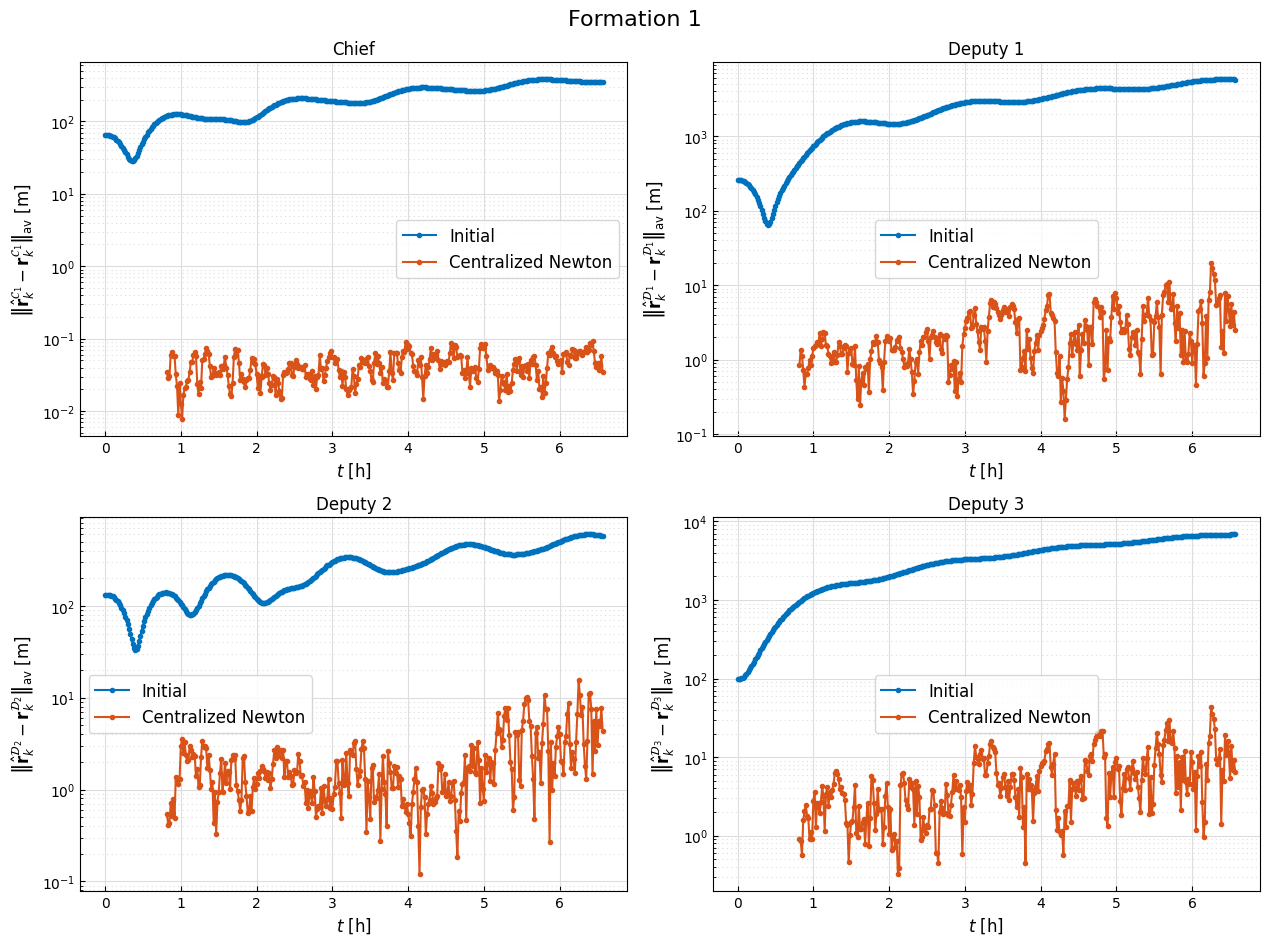

In [ ]:
# MATLAB default color cycle
matlab_default_colors = [
    [0, 0.4470, 0.7410],  # blue
    [0.8500, 0.3250, 0.0980],  # orange
    [0.9290, 0.6940, 0.1250],  # yellow
    [0.4940, 0.1840, 0.5560],  # purple
    [0.4660, 0.6740, 0.1880],  # green
    [0.3010, 0.7450, 0.9330],  # light blue
    [0.6350, 0.0780, 0.1840],  # red
]
# Set the color cycle in Matplotlib to match MATLAB's default
plt.rcParams["axes.prop_cycle"] = plt.cycler(color=matlab_default_colors)

time = np.arange(0, K) / dt
algorithm = "Centralized Newton"

# Plot positions based on screen size
fig_width = 2 * 6.4  # in inchesa
fig_height = 2 * 4.8  # in inches

# Create a 2 by 2 figure
fig, axs = plt.subplots(2, 2, figsize=(fig_width, fig_height))

# Plot 1: Chief
axs[0, 0].plot(time, position_estimation_error_1_initial, ".-", label="Initial")
axs[0, 0].plot(time[H - 1:], position_estimation_error_1, ".-", label=algorithm)
axs[0, 0].grid(which="major", color="#DDDDDD", zorder=1)
axs[0, 0].grid(which="minor", color="#DDDDDD", linestyle=(0, (1, 3)), zorder=2)
axs[0, 0].grid(True, which="both")
axs[0, 0].set_yscale("log")
axs[0, 0].set_xlabel("$t$ [h]", fontsize=12)
axs[0, 0].set_ylabel(
    "$\\left\\|\\hat{\\mathbf{r}}_k^{\\mathcal{C}_1} - \\mathbf{r}_k^{\\mathcal{C}_1}\\right\\|_\\mathrm{av}$ [m]",
    fontsize=12,
)
# axs[0, 0].set_ylim([1e-2, 1e3])
axs[0, 0].tick_params(axis="both", which="both", direction="in")
axs[0, 0].legend(fontsize=12)
axs[0, 0].set_title("Chief")

# Plot 2: Deputy 1
axs[0, 1].plot(time, position_estimation_error_2_initial, ".-", label="Initial")
axs[0, 1].plot(time[H - 1:], position_estimation_error_2, ".-", label=algorithm)
axs[0, 1].grid(which="major", color="#DDDDDD", zorder=1)
axs[0, 1].grid(which="minor", color="#DDDDDD", linestyle=(0, (1, 3)), zorder=2)
axs[0, 1].grid(True, which="both")
axs[0, 1].set_yscale("log")
axs[0, 1].set_xlabel("$t$ [h]", fontsize=12)
axs[0, 1].set_ylabel(
    "$\\left\\|\\hat{\\mathbf{r}}_k^{\\mathcal{D}_1} - \\mathbf{r}_k^{\\mathcal{D}_1}\\right\\|_\\mathrm{av}$ [m]",
    fontsize=12,
)
# axs[0, 1].set_ylim([1e-1, 1e3])
axs[0, 1].tick_params(axis="both", which="both", direction="in")
axs[0, 1].legend(fontsize=12)
axs[0, 1].set_title("Deputy 1")

# Plot 3: Deputy 2
axs[1, 0].plot(time, position_estimation_error_3_initial, ".-", label="Initial")
axs[1, 0].plot(time[H - 1:], position_estimation_error_3, ".-", label=algorithm)
axs[1, 0].grid(which="major", color="#DDDDDD", zorder=1)
axs[1, 0].grid(which="minor", color="#DDDDDD", linestyle=(0, (1, 3)), zorder=2)
axs[1, 0].grid(True, which="both")
axs[1, 0].set_yscale("log")
axs[1, 0].set_xlabel("$t$ [h]", fontsize=12)
axs[1, 0].set_ylabel(
    "$\\left\\|\\hat{\\mathbf{r}}_k^{\\mathcal{D}_2} - \\mathbf{r}_k^{\\mathcal{D}_2}\\right\\|_\\mathrm{av}$ [m]",
    fontsize=12,
)
# axs[1, 0].set_ylim([1e-1, 1e3])
axs[1, 0].tick_params(axis="both", which="both", direction="in")
axs[1, 0].legend(fontsize=12)
axs[1, 0].set_title("Deputy 2")

# Plot 4: Deputy 3
axs[1, 1].plot(time, position_estimation_error_4_initial, ".-", label="Initial")
axs[1, 1].plot(time[H - 1:], position_estimation_error_4, ".-", label=algorithm)
axs[1, 1].grid(which="major", color="#DDDDDD", zorder=1)
axs[1, 1].grid(which="minor", color="#DDDDDD", linestyle=(0, (1, 3)), zorder=2)
axs[1, 1].grid(True, which="both")
axs[1, 1].set_yscale("log")
axs[1, 1].set_xlabel("$t$ [h]", fontsize=12)
axs[1, 1].set_ylabel(
    "$\\left\\|\\hat{\\mathbf{r}}_k^{\\mathcal{D}_3} - \\mathbf{r}_k^{\\mathcal{D}_3}\\right\\|_\\mathrm{av}$ [m]",
    fontsize=12,
)
# axs[1, 1].set_ylim([1e-1, 1e3])
axs[1, 1].tick_params(axis="both", which="both", direction="in")
axs[1, 1].legend(fontsize=12)
axs[1, 1].set_title("Deputy 3")

fig.suptitle(f"Formation {formation}", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()